In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D
import pyransac3d as pyrsc
%matplotlib inline

Load the gaze_2d in tracker's camera frame


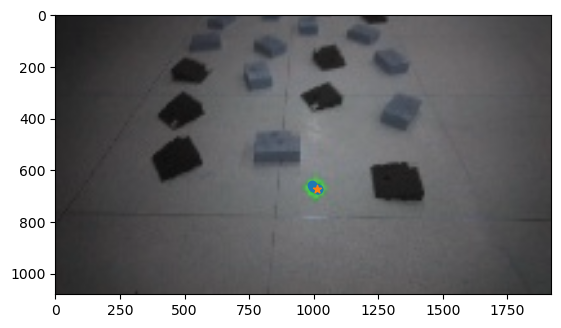

In [8]:
#path to data
gaze_2d_name = [
"/media/yuxuan/My Passport/眼动仪交接 2023.4.6/data/data/3_walking_small_Chen_12_21/test5/orbbec_gaze_2D/1608552332.214.npy",
"/media/yuxuan/My Passport/眼动仪交接 2023.4.6/data/data/3_walking_small_Chen_12_21/test5/orbbec_gaze_2D/1608552332.235.npy",
"/media/yuxuan/My Passport/眼动仪交接 2023.4.6/data/data/3_walking_small_Chen_12_21/test5/orbbec_gaze_2D/1608552332.276.npy",
"/media/yuxuan/My Passport/眼动仪交接 2023.4.6/data/data/3_walking_small_Chen_12_21/test5/orbbec_gaze_2D/1608552332.313.npy",
"/media/yuxuan/My Passport/眼动仪交接 2023.4.6/data/data/3_walking_small_Chen_12_21/test5/orbbec_gaze_2D/1608552332.358.npy",
"/media/yuxuan/My Passport/眼动仪交接 2023.4.6/data/data/3_walking_small_Chen_12_21/test5/orbbec_gaze_2D/1608552332.393.npy"
]
gaze_rgb_name = [
    "/media/yuxuan/My Passport/眼动仪交接 2023.4.6/data/data/3_walking_small_Chen_12_21/test5/glasses_frame/1608552332.214.jpg",
    "/media/yuxuan/My Passport/眼动仪交接 2023.4.6/data/data/3_walking_small_Chen_12_21/test5/glasses_frame/1608552332.235.jpg",
    "/media/yuxuan/My Passport/眼动仪交接 2023.4.6/data/data/3_walking_small_Chen_12_21/test5/glasses_frame/1608552332.276.jpg",
    "/media/yuxuan/My Passport/眼动仪交接 2023.4.6/data/data/3_walking_small_Chen_12_21/test5/glasses_frame/1608552332.313.jpg",
    "/media/yuxuan/My Passport/眼动仪交接 2023.4.6/data/data/3_walking_small_Chen_12_21/test5/glasses_frame/1608552332.358.jpg",
    "/media/yuxuan/My Passport/眼动仪交接 2023.4.6/data/data/3_walking_small_Chen_12_21/test5/glasses_frame/1608552332.393.jpg"
]
gaze_2d_list = []
for name in gaze_2d_name:
    gaze_2d_list.append(np.load(name))

gaze_2d_vec = np.asarray(gaze_2d_list)
median_gaze_2d = np.median(gaze_2d_vec, axis=0)
gaze_2d_scale = np.copy(gaze_2d_vec)
gaze_2d_scale[:,0]*=1920
gaze_2d_scale[:,1]*=1080
median_gaze_rgb = cv2.imread(gaze_rgb_name[2])
median_gaze_rgb_scale = cv2.resize(median_gaze_rgb,(1920,1080))
plt.imshow(median_gaze_rgb_scale)
plt.scatter(gaze_2d_scale[:,0],gaze_2d_scale[:,1])
plt.scatter(median_gaze_2d[0]*1920, median_gaze_2d[1]*1080, marker='*')

Some Functions.

In [4]:
default_cam_intri = np.asarray(
    [[521.85359567,   0.        , 321.18647073],
    [0.        , 521.7098714 , 233.81475134],
    [0.        ,   0.        ,   1.        ]])

def uv_vec2cloud(uv_vec, depth_img, depth_scale = 1e-3):
    '''
        uv_vec: n×2,
        depth_image: rows * cols
    '''
    fx = default_cam_intri[0, 0]
    fy = default_cam_intri[1, 1]
    cx = default_cam_intri[0, 2]
    cy = default_cam_intri[1, 2]
    cloud = np.zeros((len(uv_vec), 3))
    cloud[:, 2] = depth_img[uv_vec[:, 1].astype(int), uv_vec[:, 0].astype(int)] * depth_scale
    cloud[:, 0] = (uv_vec[:, 0] - cx) * (cloud[:, 2] / fx)
    cloud[:, 1] = (uv_vec[:, 1] - cy) * (cloud[:, 2] / fy)
    return cloud

def depth2cloud(img_depth, cam_intri_inv = None):
    # default unit of depth and point cloud is mm.
    if cam_intri_inv is None:
        cam_intri_inv = np.zeros((1, 1, 3, 3))
        cam_intri_inv[0, 0] = np.linalg.inv(default_cam_intri)
    uv_vec = np.transpose(np.mgrid[0:480, 0:640], (1, 2, 0))[:, :, [1, 0]].reshape((-1, 2))
    point_cloud = uv_vec2cloud(uv_vec, img_depth, depth_scale=1)
    return point_cloud

def cam1_to_cam2_xyz(uv_vec_1, z_vec_1, cam1_matrix, T_cam1_in_cam2):
    uv_vec_1 = uv_vec_1.reshape((-1, 2))
    num_points = uv_vec_1.shape[0]
    uv_vec_1 = np.asarray(uv_vec_1)
    uvz_vec_1 = np.ones((num_points, 3))
    uvz_vec_1[:, :2] = uv_vec_1
    uvz_vec_1 *= np.reshape(z_vec_1, (-1, 1))
    p_vec_1 = np.ones((4, num_points))
    p_vec_1[:3, :] = np.matmul(np.linalg.inv(cam1_matrix), uvz_vec_1.T)
    p_vec_2 = np.matmul(T_cam1_in_cam2, p_vec_1)
    return p_vec_2

def tracker_to_rgbd_without_depth(uv_tracker, img_depth, rgbd_tracker_paras):
    uv_tracker = uv_tracker.reshape([1, -1])
    cam_matrix_tracker = rgbd_tracker_paras.get('cam_matrix_tracker')
    T_tracker_in_depth = np.linalg.inv(rgbd_tracker_paras.get('T_mat_depth_in_tracker'))
    points_in_depth = depth2cloud(img_depth)

    start = time.time()
    p_eye_in_depth = cam1_to_cam2_xyz(uv_tracker, np.asarray([0]),
                                      cam1_matrix=cam_matrix_tracker,
                                      T_cam1_in_cam2=T_tracker_in_depth)[:3].T
    p_virtual_point_in_depth = cam1_to_cam2_xyz(uv_tracker, np.asarray([1000]),
                                                cam1_matrix=cam_matrix_tracker,
                                                T_cam1_in_cam2=T_tracker_in_depth)[:3].T

    indices = np.arange(points_in_depth.shape[0])
    np.random.shuffle(indices)

    points_in_depth = points_in_depth[indices[:10000]]
    indices = indices[:10000]

    valid_indices = np.abs(points_in_depth[:, 2]) > 100
    points_in_depth = points_in_depth[valid_indices]
    indices = indices[valid_indices]

    distance = np.linalg.norm(np.cross(points_in_depth - p_eye_in_depth,
                                       points_in_depth-p_virtual_point_in_depth), axis=-1)
    distance /= np.linalg.norm(p_eye_in_depth - p_virtual_point_in_depth, axis=-1)
    index_min = indices[np.argmin(distance)]
    v = int(np.floor(index_min / img_depth.shape[1]))
    u = index_min - v * img_depth.shape[1]
    uv_est_in_depth = np.asarray([u, v])
    print('Computing time of 2D gaze to 3D gaze: {:0f} ms'.format(1000 * (time.time() - start)))
    return uv_est_in_depth
def uvz2xyz(u, v, d, cam_intri_inv= None):
    if cam_intri_inv is None:
        cam_intri_inv = np.linalg.inv(default_cam_intri)
    uvd_vec = np.asarray([u, v, 1]) * d
    xyz = np.matmul(cam_intri_inv, uvd_vec)
    return xyz
def tracker_to_rgbd_xyz(gaze_2d,img_depth,depth_scale=1000):
    '''
    Input:
    gaze 2d: u in [0, 1], v in [0, 1]
    image depth: unit mm
    Output:
    xyz: unit m
    '''
    uv_in_tracker = gaze_2d * np.asarray([1920, 1080])
    rgbd_tracker_paras = np.load('rgbd_tracker_paras.npy', allow_pickle=True).item()
    print("T_mat_depth_in_tracker",rgbd_tracker_paras.get('T_mat_depth_in_tracker'))
    u, v = tracker_to_rgbd_without_depth(uv_in_tracker, img_depth, rgbd_tracker_paras)
    d = img_depth[v, u] / depth_scale
    return uvz2xyz(u, v, d), (u,v)

Calculate the gaze target in 3D space. And the gaze position in depth camera's coordinate.

In [9]:
depth_name = "/media/yuxuan/My Passport/眼动仪交接 2023.4.6/data/data/3_walking_small_Chen_12_21/test5/orbbec_depth/1608552332.304.png"
img_depth = cv2.imread(depth_name, cv2.IMREAD_UNCHANGED)
gaze_3d_in_depth, gaze_2d_in_depth = tracker_to_rgbd_xyz(median_gaze_2d, img_depth)

T_mat_depth_in_tracker [[ 9.99992885e-01 -3.22474755e-03 -1.95747177e-03 -4.21351422e+00]
 [ 3.35691624e-03  9.97415926e-01  7.17649114e-02 -3.22749133e+01]
 [ 1.72098979e-03 -7.17709718e-02  9.97419654e-01  4.49436395e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Computing time of 2D gaze to 3D gaze: 4.346132 ms


Gaze in depth camera frame
Gaze in tracker camera frame


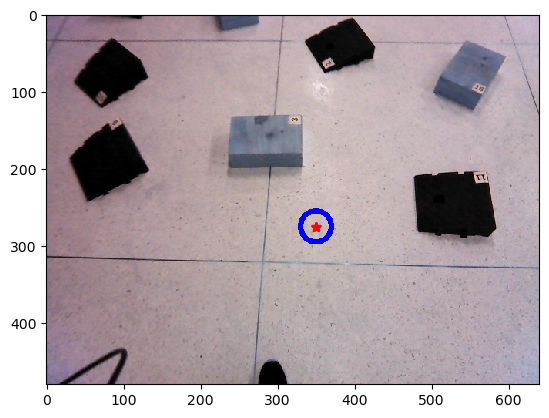

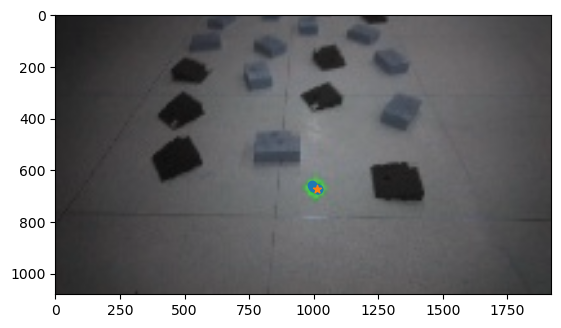

In [6]:
rgb_img_name = "/media/yuxuan/My Passport/眼动仪交接 2023.4.6/data/data/3_walking_small_Chen_12_21/test5/orbbec_rgb/1608552332.304.jpg"
img_depth_camera = cv2.imread(rgb_img_name)
print("Gaze in depth camera frame")
cv2.circle(img_depth_camera, gaze_2d_in_depth,radius=20,color=(0,0,255),thickness=5)
plt.imshow(img_depth_camera)
plt.scatter(gaze_2d_in_depth[0],
            gaze_2d_in_depth[1],marker="*",linewidths=2,color='r')
plt.figure()
print("Gaze in tracker camera frame")
plt.imshow(median_gaze_rgb_scale)
plt.scatter(gaze_2d_scale[:,0],gaze_2d_scale[:,1])
plt.scatter(median_gaze_2d[0]*1920, median_gaze_2d[1]*1080, marker='*')

/usr/local/lib/python3.8/dist-packages/pyransac3d/plane.py:59: RuntimeWarning: invalid value encountered in divide
  vecC = vecC / np.linalg.norm(vecC)


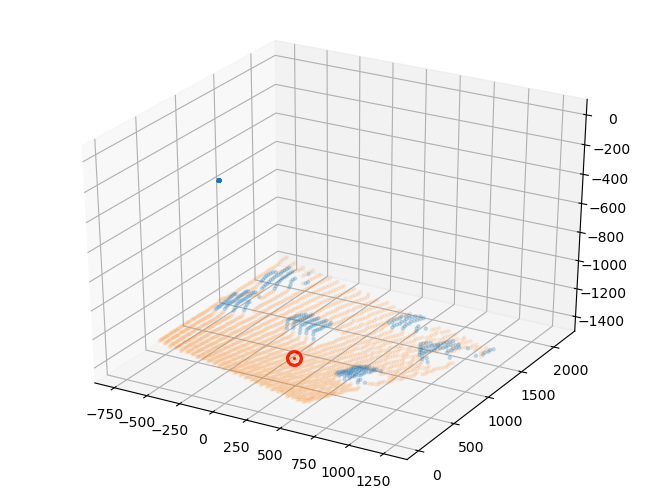

In [7]:
points_in_depth = np.asarray(depth2cloud(img_depth))
fig = plt.figure()
ax = Axes3D(fig)
points_in_depth = points_in_depth[0:-1:100,:]
plane = pyrsc.Plane()
best_eq, best_inliers = plane.fit(points_in_depth, 20)
all_idx = np.arange(0,np.shape(points_in_depth)[0])
not_inliers = np.delete(all_idx, best_inliers)
best_eq = np.array(best_eq)
if best_eq[2]<0:
    best_eq = -best_eq
plane_zaxis = -best_eq[0:-1]/np.linalg.norm(best_eq[0:-1])

axis_theta = np.arccos(np.dot(np.array([0,0,1]),plane_zaxis))
axis_v1v2 = np.cross(np.array([0,0,1]),plane_zaxis)
axis_v1v2 = axis_v1v2/np.linalg.norm(axis_v1v2)
R_mat,_ = cv2.Rodrigues(axis_theta*axis_v1v2)
points_in_depth = np.matmul(R_mat.T,points_in_depth.T).T
points_gaze = gaze_3d_in_depth*1000
points_gaze = np.matmul(R_mat.T,points_gaze.T).T
points_foot = points_in_depth[np.where(
    np.linalg.norm(
        points_in_depth-points_gaze,axis=1
    )<50
)[0],:]
ax.scatter(points_in_depth[not_inliers,0],
           points_in_depth[not_inliers,1],
           points_in_depth[not_inliers,2],alpha=0.2,marker='.')
ax.scatter(points_in_depth[best_inliers,0],
           points_in_depth[best_inliers,1],
           points_in_depth[best_inliers,2],alpha=0.1,marker='.')
# ax.scatter(points_foot[:,0],points_foot[:,1],points_foot[:,2],linewidths=2,color='g',marker='x')
ax.scatter(points_gaze[0],points_gaze[1],points_gaze[2],linewidths=10,color='r',marker='.')